In [2]:
#!gdown 15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t

#!tar -xzf aclImdb_v1.tar.gz
#!rm -r aclImdb/train/unsup

In [17]:
from dotenv import load_dotenv
load_dotenv('../.env')


True

In [1]:
import keras

train_ds, val_ds = keras.utils.text_dataset_from_directory(
    '../data/aclImdb/train', validation_split=0.2, subset='both', seed=42
)
test_ds = keras.utils.text_dataset_from_directory('../data/aclImdb/test')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


2025-08-19 11:41:20.636509: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-08-19 11:41:20.636531: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-08-19 11:41:20.636538: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-08-19 11:41:20.636550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-19 11:41:20.636559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25000 files belonging to 2 classes.


In [5]:
import keras_nlp

roberta_classifier = keras_nlp.models.RobertaClassifier.from_preset(
    'roberta_base_en',
    num_classes=2,
)

roberta_classifier.summary()

roberta_tokenizer = roberta_classifier.preprocessor.tokenizer
roberta_classifier.optimizer.learning_rate.assign(5e-6)

Preprocessor: "roberta_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ roberta_tokenizer (RobertaTokenizer)                          │                       Vocab size: 50,265 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "roberta_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ roberta_backbone              │ (None, None, 768)         │     124,052,736 │ padding_mask[0][0],        │
│ (RobertaBackbone)             │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ roberta_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │               0 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,644,866 (475.48 MB)

 Trainable params: 124,644,866 (475.48 MB)

 Non-trainable params: 0 (0.00 B)

<tf.Tensor: shape=(), dtype=float32, numpy=5e-06>

In [6]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
)

# ModelCheckpoint 콜백 추가
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath='roberta_checkpoint.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)


In [7]:
hist_roberta = roberta_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping_cb, checkpoint_cb],
)

Epoch 1/20


2025-08-12 21:07:41.041565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 1616s 3s/step - loss: 0.3762 - sparse_categorical_accuracy: 0.8006 - val_loss: 0.1593 - val_sparse_categorical_accuracy: 0.9392
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1809s 3s/step - loss: 0.1504 - sparse_categorical_accuracy: 0.9451 - val_loss: 0.1549 - val_sparse_categorical_accuracy: 0.9442
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1856s 3s/step - loss: 0.1154 - sparse_categorical_accuracy: 0.9608 - val_loss: 0.1583 - val_sparse_categorical_accuracy: 0.9448
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8576s 14s/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.1612 - val_sparse_categorical_accuracy: 0.9452
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2212s 4s/step - loss: 0.0606 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.1866 - val_sparse_categorical_accuracy: 0.9420


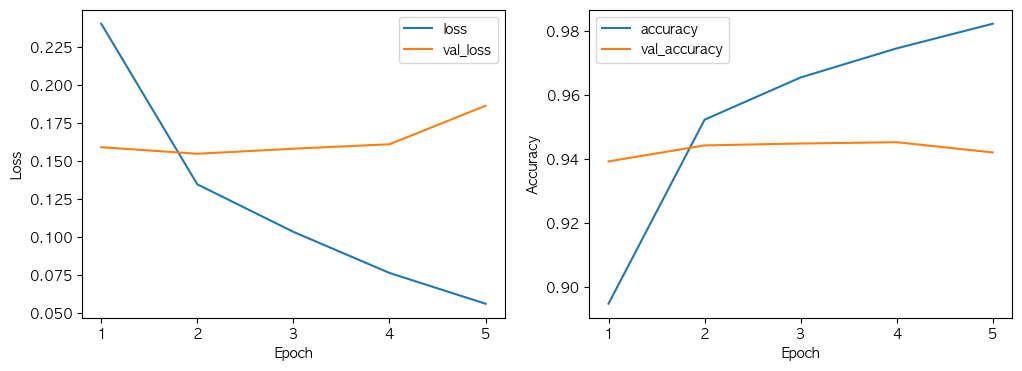

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

epochs = np.array(hist_roberta.epoch) + 1
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(epochs, hist_roberta.history['loss'], label='loss')
axs[0].plot(epochs, hist_roberta.history['val_loss'], label='val_loss')
axs[0].set_xticks(epochs)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, hist_roberta.history['sparse_categorical_accuracy'], label='accuracy')
axs[1].plot(epochs, hist_roberta.history['val_sparse_categorical_accuracy'], label='val_accuracy')
axs[1].set_xticks(epochs)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()


In [9]:
roberta_classifier.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 555s 709ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.9529


[0.13152575492858887, 0.953000009059906]

In [4]:
from transformers import pipeline

pipe = pipeline(task='text-classification', device=0,
                model='WhitePeak/bert-base-cased-Korean-sentiment')

Device set to use mps:0


In [5]:
import keras_nlp

distilbert_classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    'distil_bert_base_en_uncased',
    num_classes=2,
)

distilbert_classifier.summary()

distilbert_tokenizer = distilbert_classifier.preprocessor.tokenizer
distilbert_classifier.optimizer.learning_rate.assign(5e-6)

Preprocessor: "distil_bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

<tf.Tensor: shape=(), dtype=float32, numpy=5e-06>

In [ ]:
from transformers import pipeline

pipe = pipeline(task='text-classification', device=0,
                model='distilbert/distilbert-base-uncased')



Device set to use mps:0


In [8]:
from datasets import load_dataset

imdb = load_dataset('imdb')

print(imdb)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [9]:
test_slice = imdb['test'].shuffle(seed=42).select(range(5000))

In [15]:
from evaluate import evaluator

task_evaluator = evaluator("text-classification")

task_evaluator.compute(
    model_or_pipeline=pipe,
    data=test_slice,
    metric="accuracy",
    input_column="text",
    label_column="label",
    label_mapping={"NEGATIVE": 0, "POSITIVE": 1}
)

ValueError: Incompatible `model_or_pipeline`. Please specify `model_or_pipeline` compatible with the `text-classification` task.

In [7]:
pipe = pipeline(task='text-classification', device=0,
                model='distilbert/distilbert-base-uncased-finetuned-sst-2-english')

#pipe.model.summary()

Device set to use mps:0


In [19]:
task_evaluator.compute(
    model_or_pipeline='distilbert/distilbert-base-uncased-finetuned-sst-2-english',
    data=test_slice,
    metric="accuracy",
    input_column="text",
    label_column="label",
    device=0,    label_mapping={"NEGATIVE": 0, "POSITIVE": 1}
)

Device set to use cpu


{'accuracy': 0.8954,
 'total_time_in_seconds': 129.79738600000564,
 'samples_per_second': 38.52157700617933,
 'latency_in_seconds': 0.02595947720000113}